In [1]:
import numpy as np
import pandas as pd
import warnings
from rdkit import RDLogger
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from IPython.core.display import HTML
from rdkit.Chem.QED import qed
from rdkit.Chem import PandasTools
def show(df):
    return HTML(df.to_html(notebook=True))
PandasTools.RenderImagesInAllDataFrames(images=True)

In [2]:
results_phBr=pd.read_pickle('generated_phBr.pkl')

In [3]:
results_phB=pd.read_pickle('generated_phB.pkl')

In [4]:
results=pd.merge(results_phBr.assign(key=0), results_phB.assign(key=0), on='key').drop('key', axis=1)

In [5]:
len(results)

91350

/home/cbe/anaconda3/envs/py39/lib/python3.9/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,molecule_x,smiles_x,molecule_y,smiles_y
0,,Brc1ccccc1,,OB(O)c1ccccc1

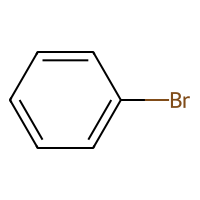
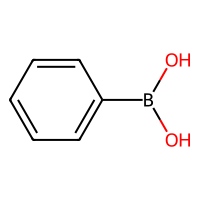

In [6]:
results.head(1)

In [7]:
reaction_template=['[F,Cl,Br,I]-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3].O-B(-O)-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]>>[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]',
                       'S(C(F)(F)F)(=O)(=O)O-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3].O-B(-O)-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]>>S(C(F)(F)F)(=O)(=O)O-[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]',
                  'O-B(-O)-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6].[F,Cl,Br,I]-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3]>>[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]',
                  'O-B(-O)-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6].S(C(F)(F)F)(=O)(=O)O-[c;H0;D3;+0:1](:[c,n:2]):[c,n:3]>>S(C(F)(F)F)(=O)(=O)O-[c,n:2]:[c;H0;D3;+0:1](:[c,n:3])-[c;H0;D3;+0:4](:[c,n:5]):[c,n:6]']
reaction_template_list=[]
for rxn in reaction_template:
    rxn=AllChem.ReactionFromSmarts(rxn)
    reaction_template_list.append(rxn)

In [8]:
def remove_duplicate_mols(mols):
    unique_mols = []
    smiles_dict = {}
    for mol in mols:
        # 将分子对象转换为规范SMILES
        smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
        # 将规范SMILES作为字典的键来判断分子是否重复
        if smiles not in smiles_dict:
            # 将分子添加到列表和字典中
            smiles_dict[smiles] = True
            unique_mols.append(mol)
    return unique_mols
    
def generate_product_from_template(mol_A,mol_B,rxn_tem_list):
    ps_1d_unique=[]
    for rxn in rxn_tem_list:
        ps = rxn.RunReactants((mol_A,mol_B))
        ps_1d = [x[0] for x in ps]
        ps_1d_unique=remove_duplicate_mols(ps_1d)
        if len(ps_1d_unique)>=1:
            break
    if len(ps_1d_unique)==0:
           ps_1d_unique.append(None) 
    return ps_1d_unique[0]

def get_new_reaction(mol_A,mol_B,rxn_tem_list):
    mol_A=Chem.MolFromSmiles(mol_A)
    mol_B=Chem.MolFromSmiles(mol_B)
    pt=generate_product_from_template(mol_A,mol_B,rxn_tem_list)
    generate_rxn=''
    if pt!=None:
        pt_smi=Chem.MolToSmiles(pt)
        A_smi=Chem.MolToSmiles(mol_A)
        B_smi=Chem.MolToSmiles(mol_B)
        generate_rxn=f'{A_smi}.{B_smi}>>{pt_smi}'
    return generate_rxn

In [9]:
get_new_reaction('CCC1OC(c2c(F)cccc2F)=NC1c1ccc(B(O)O)cc1','CCc1cc(S)ccc1Br',reaction_template_list)

'CCC1OC(c2c(F)cccc2F)=NC1c1ccc(B(O)O)cc1.CCc1cc(S)ccc1Br>>CCc1cc(S)ccc1-c1ccc(C2N=C(c3c(F)cccc3F)OC2CC)cc1'

In [10]:
from tqdm import tqdm
new_negative_rxn=[]
for i,j in tqdm(zip(results['smiles_x'],results['smiles_y'])):
    new_rxn=get_new_reaction(i,j,reaction_template_list)
    new_negative_rxn.append(new_rxn)

91350it [00:45, 2013.36it/s]


In [11]:
new_negative_rxn = [x for x in new_negative_rxn if x != '']

In [12]:
len(new_negative_rxn)

90048

In [ ]:
new_rxn_df.to_csv('new_rxn_df.csv')

In [13]:
new_rxn_dict = {
    'rxn_smiles': []}
for new_rxn in new_negative_rxn:
    new_rxn_dict['rxn_smiles'].append(new_rxn)


In [14]:
new_rxn_df = pd.DataFrame(new_rxn_dict)

In [15]:
new_rxn_df_subset=new_rxn_df.sample(frac=0.45, random_state=42)

In [50]:
len(new_rxn_df_subset)

124155

In [51]:
new_rxn_df_subset.to_csv('new_rxn_df_subset.csv')

In [8]:
results['sim_average'] = results[['sim_phbr', 'sim_ph_acid']].mean(axis=1)

In [9]:
results['total_sphere']=results['sphere_phbr']+results['sphere_ph_acid']

In [10]:
from generate_product import generate_product_from_template
results['product_mol'] = results.apply(lambda x: generate_product_from_template(x['smiles_phbr'], x['smiles_ph_acid']), axis=1)

/root/uspto/generation_result/ASKCOS.py:511: FutureWarning: Possible nested set at position 4
  atom_tags_in_reactant_fragments = re.findall('\:([[0-9]+)\]', reactant_fragments)


,molecule_phbr,smiles_phbr,sim_phbr,charge_phbr,sphere_phbr,molecule_ph_acid,smiles_ph_acid,sim_ph_acid,charge_ph_acid,sphere_ph_acid,sim_average,total_sphere,product_mol
0,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1ccccc1,1.000000,-0.017993,0.944321,1.000000,1.895624,
1,,Brc1ccccc1,1.000000,0.017475,0.951303,,CCc1ccc(B(O)O)cc1,0.909091,-0.017974,0.945261,0.954545,1.896563,
2,,Brc1ccccc1,1.000000,0.017475,0.951303,,Cc1ccccc1B(O)O,0.909091,-0.015063,1.025565,0.954545,1.976867,
3,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1cc2ccccc2c2ccccc12,0.882353,-0.009500,1.036403,0.941176,1.987706,
4,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1cccc2ccccc12,0.882353,-0.010138,0.997194,0.941176,1.948497,
...,...,...,...,...,...,...,...,...,...,...,...,...,...
110868,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,COCCCC(C)(C)c1c(B(O)O)ccc2c(O)cccc12,0.491803,-0.013594,1.088686,0.366591,2.102503,
110869,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,CNCCOc1ccccc1-c1cccc(-c2ccccc2)c1B(O)O,0.483871,-0.002148,0.970652,0.362625,1.984469,
110870,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,COCCc1ccc2cccc(ON)c2c1B(O)O,0.483871,-0.003026,1.055710,0.362625,2.069528,
110871,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,NCc1c(CCO)cnnc1B(O)O,0.476190,0.098429,0.919798,0.358785,1.933615,

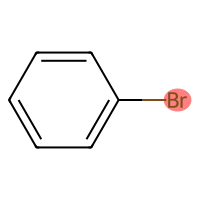
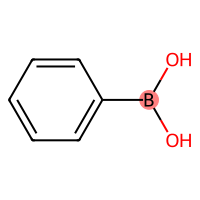
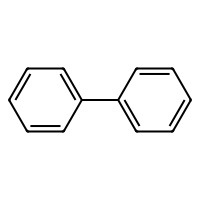
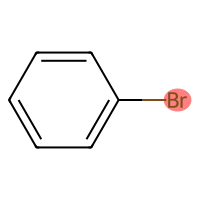
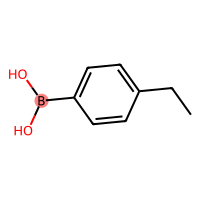
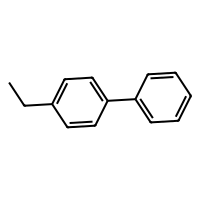
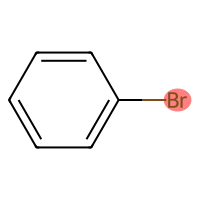
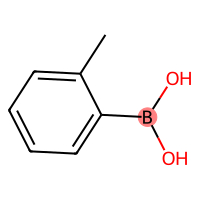
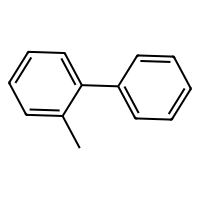
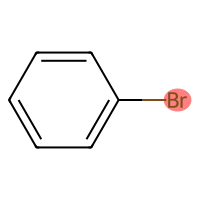
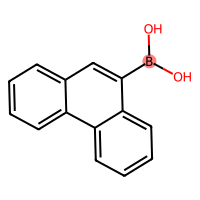
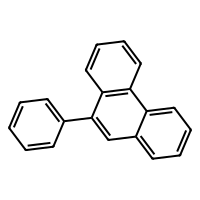
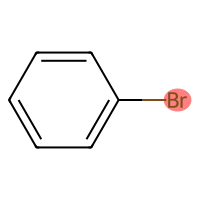
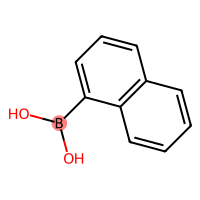
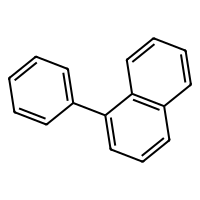
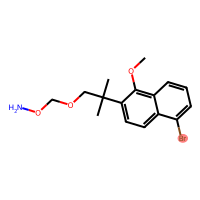
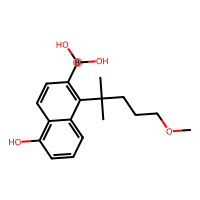
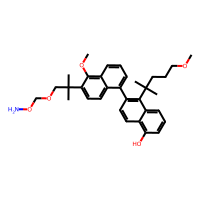
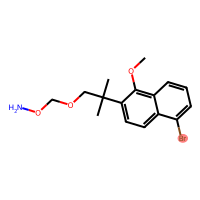
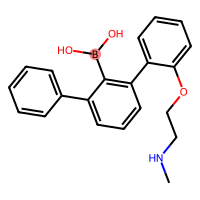
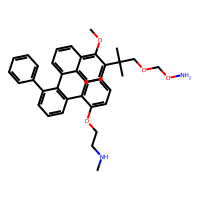
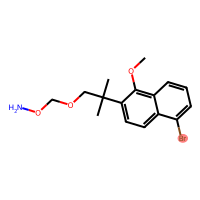
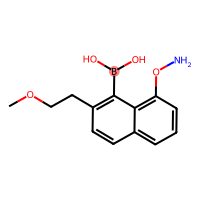
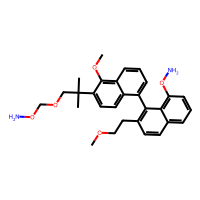
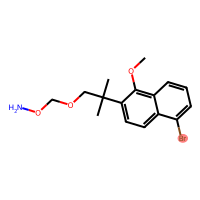
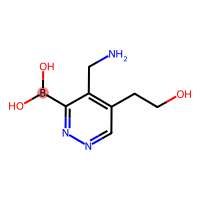
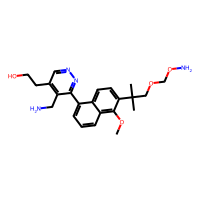
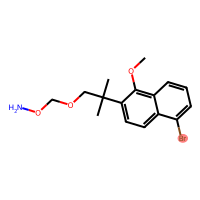
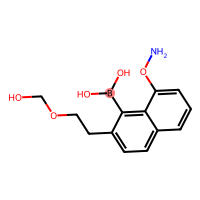
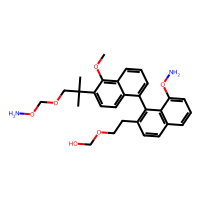

In [11]:
results

In [12]:
results= results[results['product_mol'] != 0]

In [16]:
results['product_smiles'] = results['product_mol'].apply(lambda x: Chem.MolToSmiles(x))

/tmp/ipykernel_41790/2826666184.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['product_smiles'] = results['product_mol'].apply(lambda x: Chem.MolToSmiles(x))


In [18]:
results['rxn_smiles'] = results.apply(lambda x: x['smiles_phbr'] + '.' + x['smiles_ph_acid'] + '>>' + x['product_smiles'], axis=1)

/tmp/ipykernel_41790/1595547297.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['rxn_smiles'] = results.apply(lambda x: x['smiles_phbr'] + '.' + x['smiles_ph_acid'] + '>>' + x['product_smiles'], axis=1)


,molecule_phbr,smiles_phbr,sim_phbr,charge_phbr,sphere_phbr,molecule_ph_acid,smiles_ph_acid,sim_ph_acid,charge_ph_acid,sphere_ph_acid,sim_average,total_sphere,product_mol,product_smiles,rxn_smiles
0,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1ccccc1,1.000000,-0.017993,0.944321,1.000000,1.895624,,c1ccc(-c2ccccc2)cc1,Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1
1,,Brc1ccccc1,1.000000,0.017475,0.951303,,CCc1ccc(B(O)O)cc1,0.909091,-0.017974,0.945261,0.954545,1.896563,,CCc1ccc(-c2ccccc2)cc1,Brc1ccccc1.CCc1ccc(B(O)O)cc1>>CCc1ccc(-c2ccccc...
2,,Brc1ccccc1,1.000000,0.017475,0.951303,,Cc1ccccc1B(O)O,0.909091,-0.015063,1.025565,0.954545,1.976867,,Cc1ccccc1-c1ccccc1,Brc1ccccc1.Cc1ccccc1B(O)O>>Cc1ccccc1-c1ccccc1
3,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1cc2ccccc2c2ccccc12,0.882353,-0.009500,1.036403,0.941176,1.987706,,c1ccc(-c2cc3ccccc3c3ccccc23)cc1,Brc1ccccc1.OB(O)c1cc2ccccc2c2ccccc12>>c1ccc(-c...
4,,Brc1ccccc1,1.000000,0.017475,0.951303,,OB(O)c1cccc2ccccc12,0.882353,-0.010138,0.997194,0.941176,1.948497,,c1ccc(-c2cccc3ccccc23)cc1,Brc1ccccc1.OB(O)c1cccc2ccccc12>>c1ccc(-c2cccc3...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110868,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,COCCCC(C)(C)c1c(B(O)O)ccc2c(O)cccc12,0.491803,-0.013594,1.088686,0.366591,2.102503,,COCCCC(C)(C)c1c(-c2cccc3c(OC)c(C(C)(C)COCON)cc...,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12.COCCCC(C)(C...
110869,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,CNCCOc1ccccc1-c1cccc(-c2ccccc2)c1B(O)O,0.483871,-0.002148,0.970652,0.362625,1.984469,,CNCCOc1ccccc1-c1cccc(-c2ccccc2)c1-c1cccc2c(OC)...,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12.CNCCOc1cccc...
110870,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,COCCc1ccc2cccc(ON)c2c1B(O)O,0.483871,-0.003026,1.055710,0.362625,2.069528,,COCCc1ccc2cccc(ON)c2c1-c1cccc2c(OC)c(C(C)(C)CO...,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12.COCCc1ccc2c...
110871,,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12,0.241379,0.025461,1.013818,,NCc1c(CCO)cnnc1B(O)O,0.476190,0.098429,0.919798,0.358785,1.933615,,COc1c(C(C)(C)COCON)ccc2c(-c3nncc(CCO)c3CN)cccc12,COc1c(C(C)(C)COCON)ccc2c(Br)cccc12.NCc1c(CCO)c...

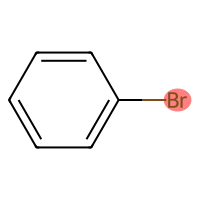
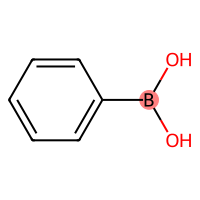
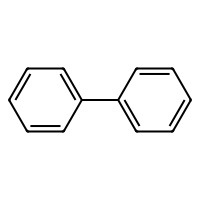
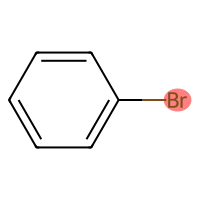
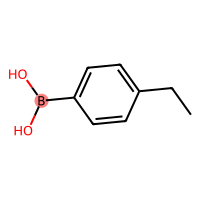
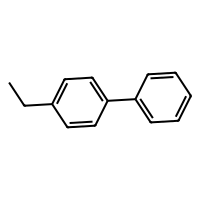
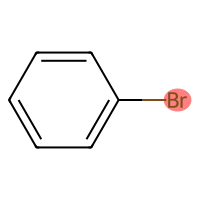
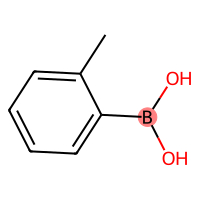
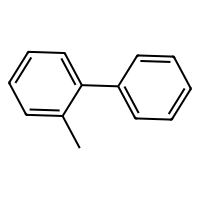
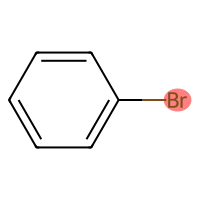
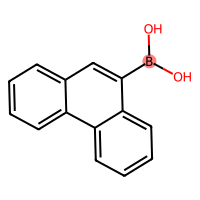
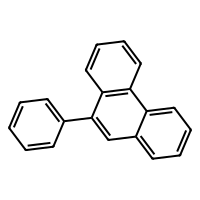
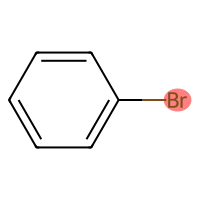
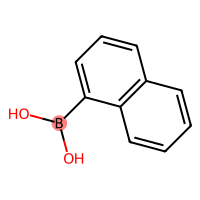
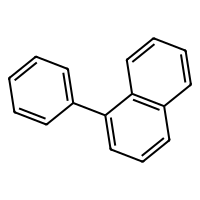
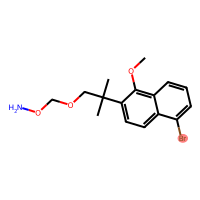
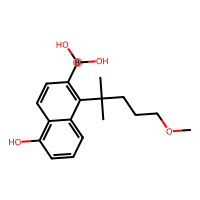
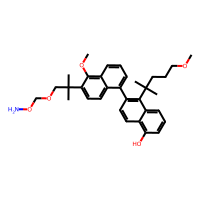
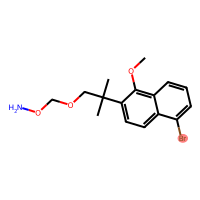
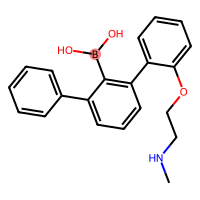
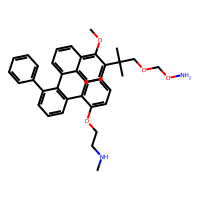
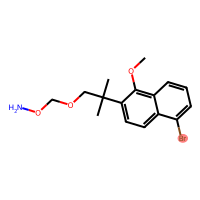
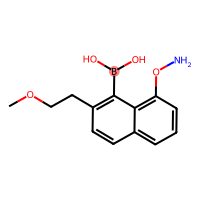
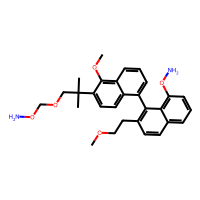
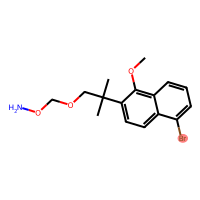
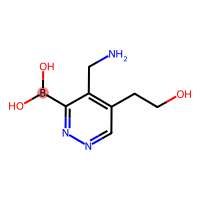
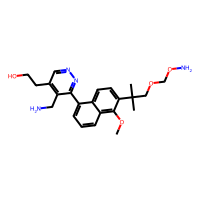
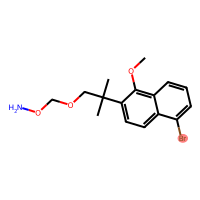
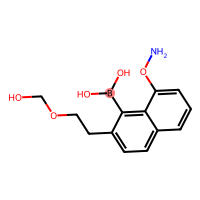
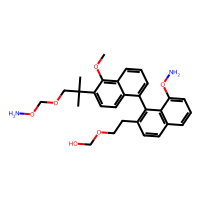

In [19]:
results

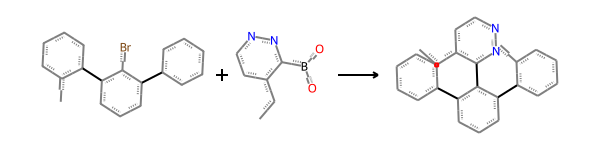

In [46]:
rxn=AllChem.ReactionFromSmarts(results.loc[10000, 'rxn_smiles'])
rxn

In [35]:
from rxnfp.transformer_fingerprints import (
    RXNBERTFingerprintGenerator, get_default_model_and_tokenizer, generate_fingerprints
)
model, tokenizer = get_default_model_and_tokenizer()

rxnfp_generator = RXNBERTFingerprintGenerator(model, tokenizer)

In [60]:
rxn1 = "Brc1ccccc1.OB(O)c1ccccc1>>c1ccc(-c2ccccc2)cc1"
rxn2='Brc1ccccc1.Cc1ccccc1B(O)O>>Cc1ccccc1-c1ccccc1'
rxn3="OB(O)c1ccccc1.Brc1ccccc1>>c1ccc(-c2ccccc2)cc1"
fp1 = rxnfp_generator.convert(rxn1)
fp2 = rxnfp_generator.convert(rxn2)
fp3= rxnfp_generator.convert(rxn3)

In [61]:
cos_sim_12 = np.dot(fp1, fp2) / (np.linalg.norm(fp1) * np.linalg.norm(fp2))
cos_sim_13 = np.dot(fp1, fp3) / (np.linalg.norm(fp1) * np.linalg.norm(fp3))

In [62]:
cos_sim_12,cos_sim_13

(0.9857614878225119, 0.9930419770878884)

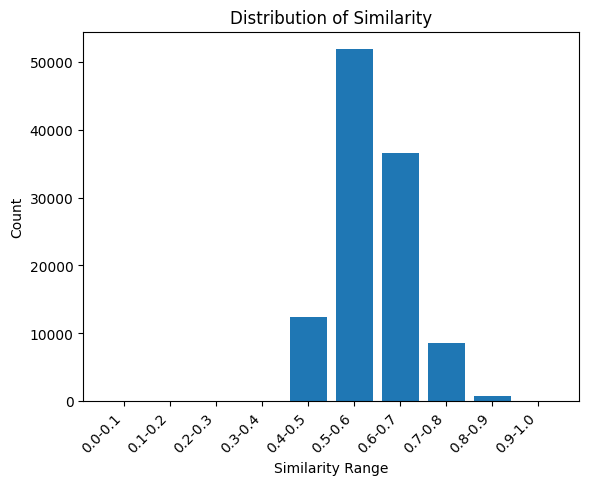

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sim_list = results['sim_average']
bins = np.linspace(0, 1, 11)
labels = [f'{i:.1f}-{j:.1f}' for i, j in zip(bins[:-1], bins[1:])]
sim_range = pd.cut(sim_list, bins=bins, labels=labels)
counts = sim_range.value_counts().sort_index()

plt.bar(counts.index, counts.values)
plt.xlabel('Similarity Range')
plt.ylabel('Count')
plt.title('Distribution of Similarity')
plt.xticks(rotation=45, ha='right')
plt.show()

In [11]:
results= results.sort_values(by='sim_average', ascending=False)

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
results.insert(1, 'molecule_ph_acid1', results['molecule_ph_acid'])

In [14]:
results = results.drop('molecule_ph_acid', axis=1)
results = results.rename(columns={'molecule_ph_acid1': 'molecule_ph_acid'})

In [15]:
results.insert(2, 'sim_average1', results['sim_average'])
results = results.drop('sim_average', axis=1)
results = results.rename(columns={'sim_average1': 'sim_average'})

In [16]:
results = results.drop('smiles_phbr', axis=1)
results = results.drop('smiles_ph_acid', axis=1)

In [17]:
results.to_csv('my_data.csv', index=False)

In [51]:
suzuki_label=pd.read_excel('suzuki_label.xlsx')

In [52]:
suzuki = pd.merge(results, suzuki_label, left_index=True, right_on='Index')

,molecule_phbr,molecule_ph_acid,sim_average,sim_phbr,charge_phbr,sphere_phbr,sim_ph_acid,charge_ph_acid,sphere_ph_acid,total_sphere,Index,Label,Max_Yiled
0,,,1.000000,1.000000,0.017475,0.951303,1.000000,-0.017993,0.944321,1.895624,0,Y,1.00
1,,,0.966667,0.933333,0.017739,0.952074,1.000000,-0.017993,0.944321,1.896396,337,Y,1.00
2,,,0.954545,1.000000,0.017475,0.951303,0.909091,-0.015063,1.025565,1.976867,2,Y,1.00
3,,,0.941176,1.000000,0.017475,0.951303,0.882353,-0.009500,1.036403,1.987706,3,Y,0.98
4,,,0.941176,1.000000,0.017475,0.951303,0.882353,-0.010138,0.997194,1.948497,4,Y,1.00

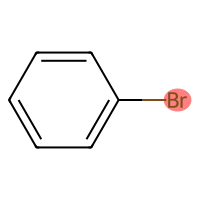
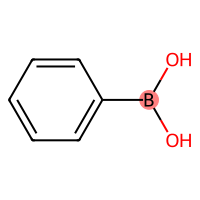
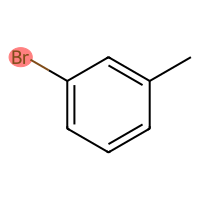
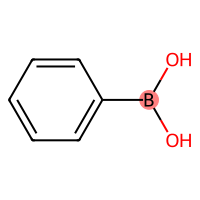
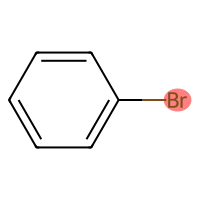
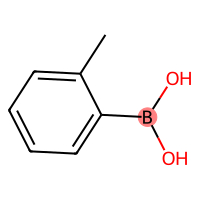
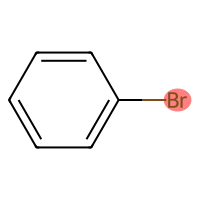
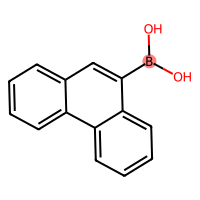
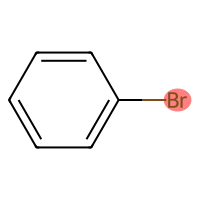
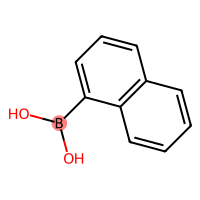

In [56]:
suzuki.head()

In [57]:
suzuki.to_pickle('suzuki.pkl')

,molecule_phbr,molecule_ph_acid,sim_average,sim_phbr,charge_phbr,sphere_phbr,sim_ph_acid,charge_ph_acid,sphere_ph_acid,total_sphere
155,,,0.840909,1.000000,0.017475,0.951303,0.681818,-0.010465,1.019247,1.970549
156,,,0.840909,1.000000,0.017475,0.951303,0.681818,-0.013980,1.015916,1.967218
157,,,0.840909,1.000000,0.017475,0.951303,0.681818,-0.002148,0.973261,1.924563
162,,,0.840909,1.000000,0.017475,0.951303,0.681818,-0.009929,1.031068,1.982370
161,,,0.840909,1.000000,0.017475,0.951303,0.681818,-0.006283,1.046666,1.997968
160,,,0.840909,1.000000,0.017475,0.951303,0.681818,0.092151,0.956349,1.907652
1018,,,0.840336,0.823529,0.036123,0.971868,0.857143,-0.002285,1.052137,2.024005
1697,,,0.840336,0.823529,0.030833,0.884286,0.857143,-0.014943,0.942331,1.826617
1696,,,0.840336,0.823529,0.030833,0.884286,0.857143,-0.002275,1.050498,1.934784
1362,,,0.840336,0.823529,0.020398,1.041879,0.857143,-0.010138,0.958582,2.000461

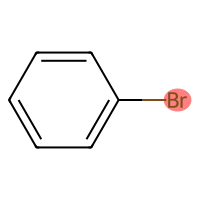
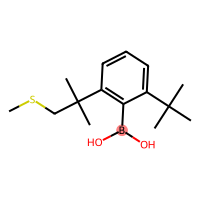
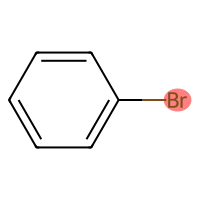
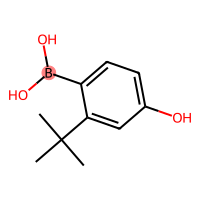
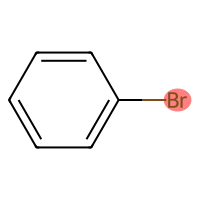
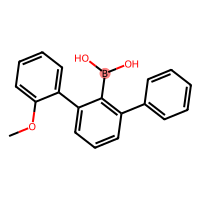
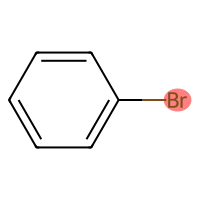
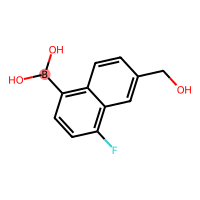
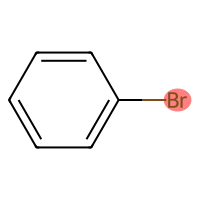
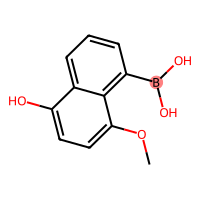
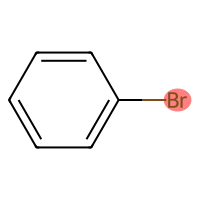
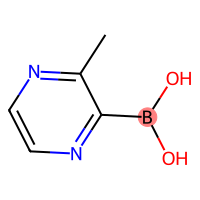
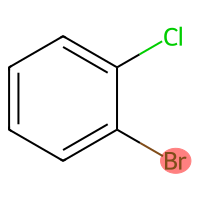
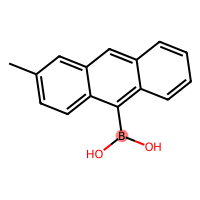
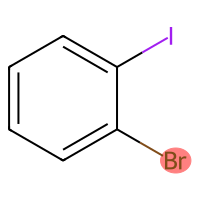
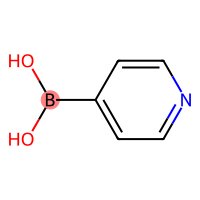
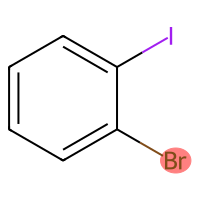
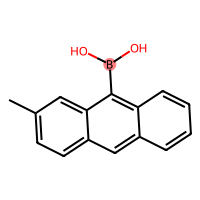
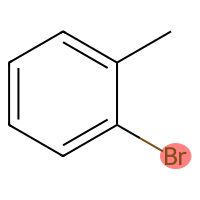
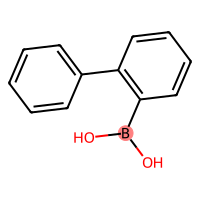
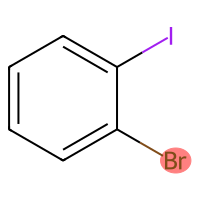
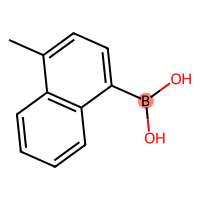
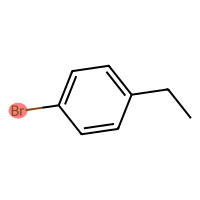
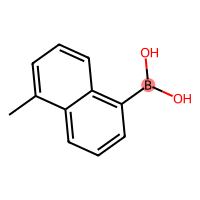
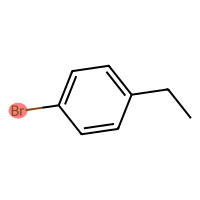
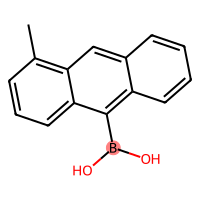
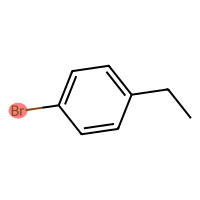
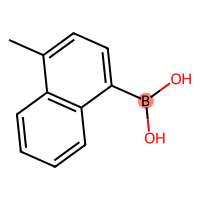
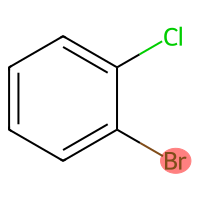
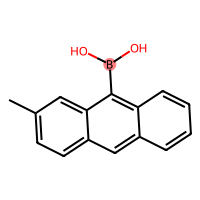
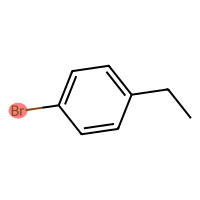
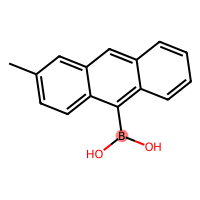
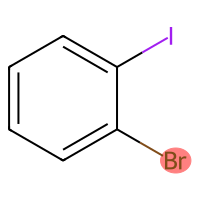
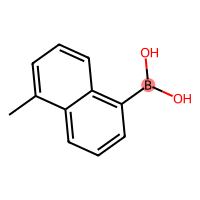
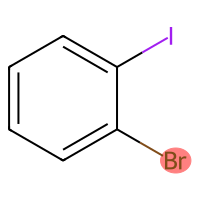
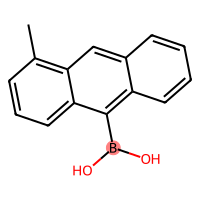
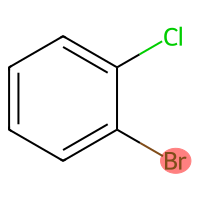
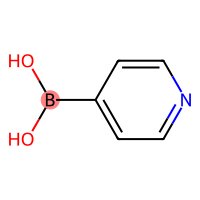
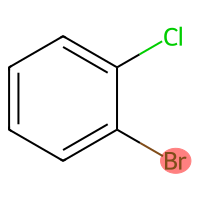
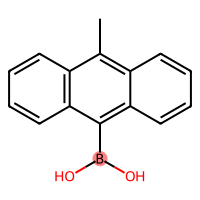
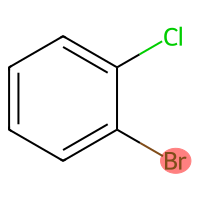
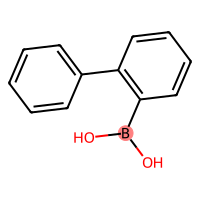
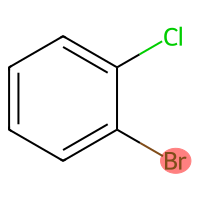
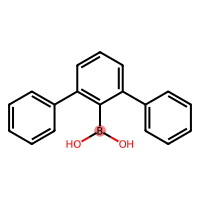
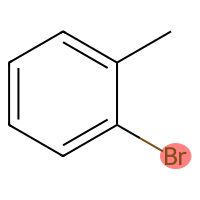
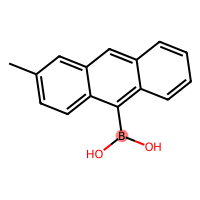
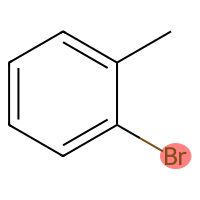
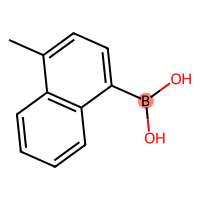
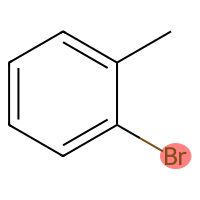
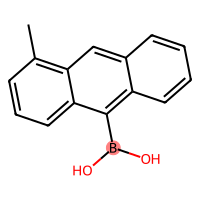
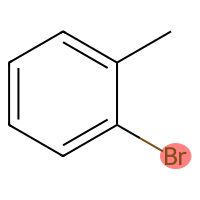
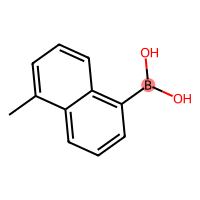
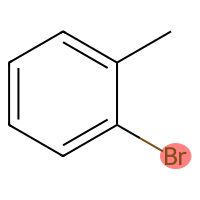
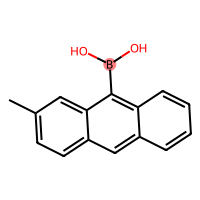
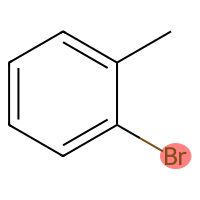
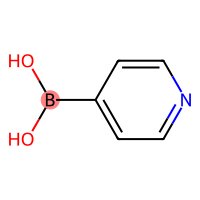
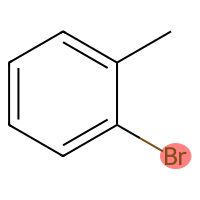
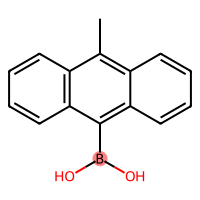
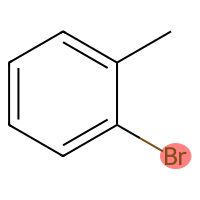
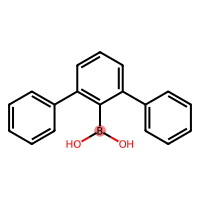
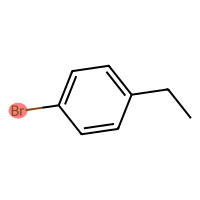
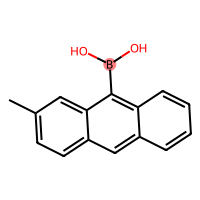
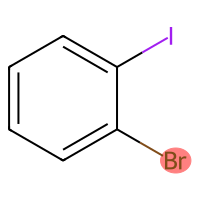
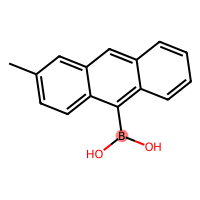
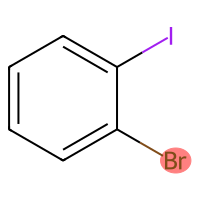
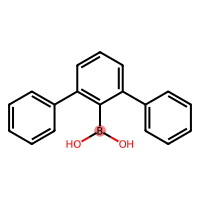
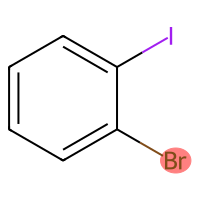
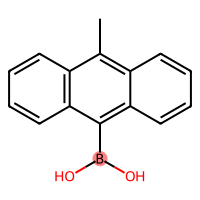
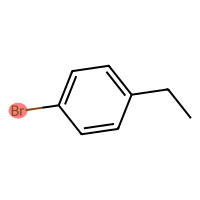
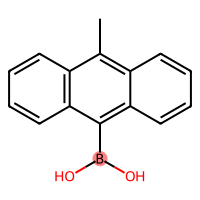
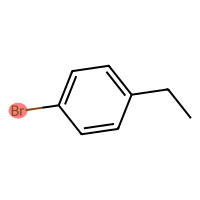
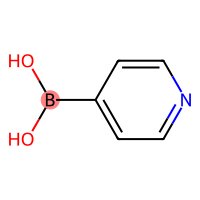
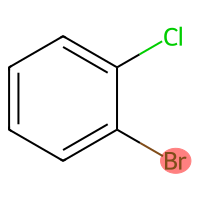
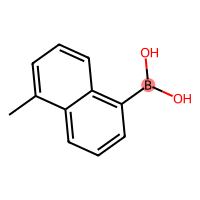
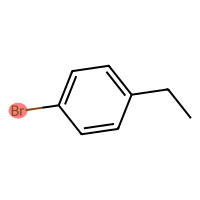
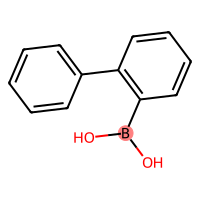
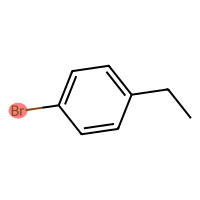
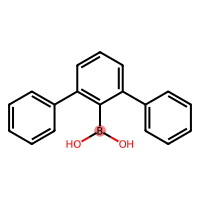
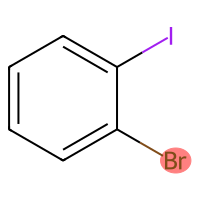
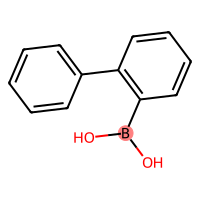
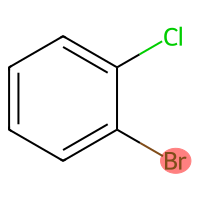
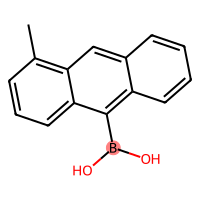
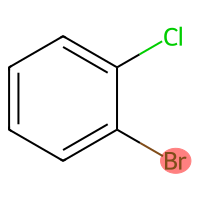
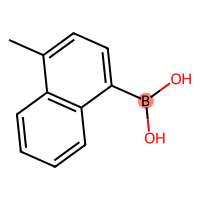
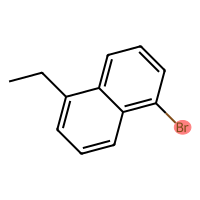
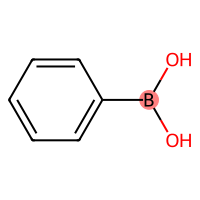
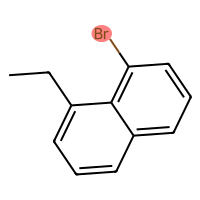
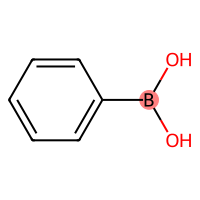
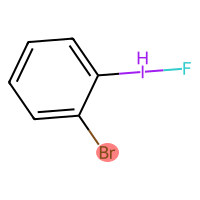
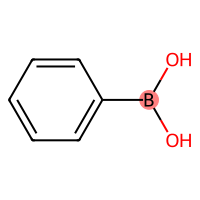
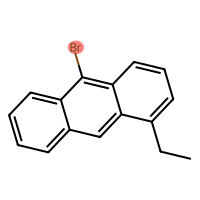
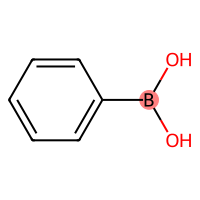
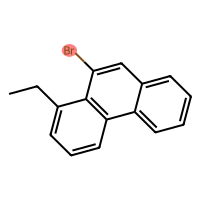
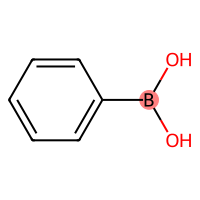
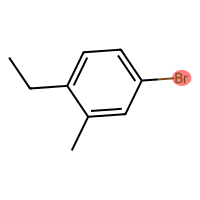
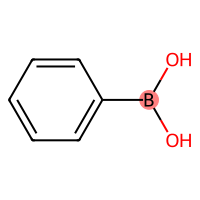
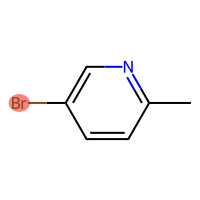
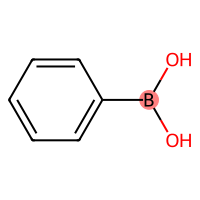
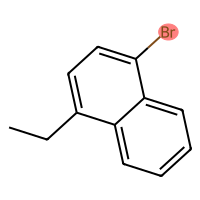
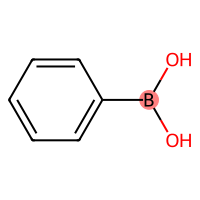
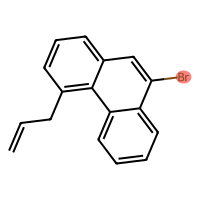
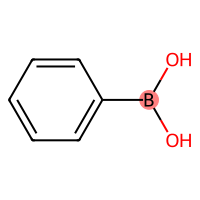
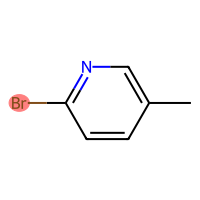
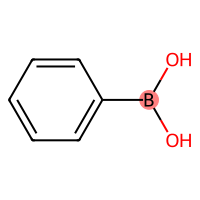
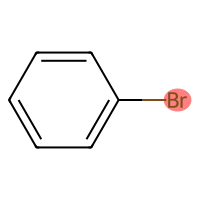
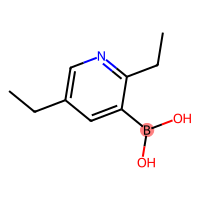
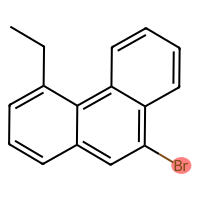
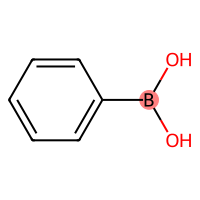
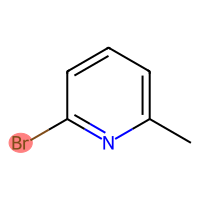
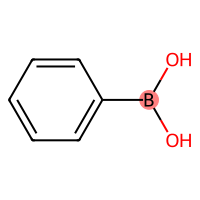
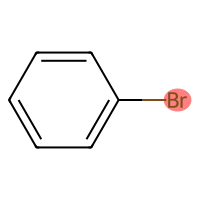
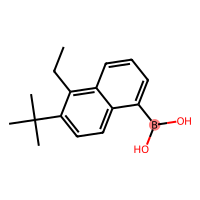
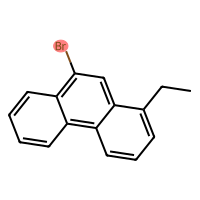
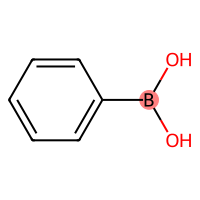
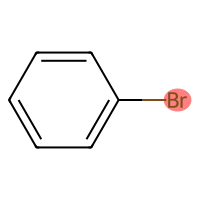
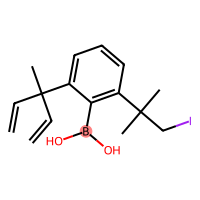
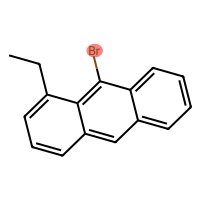
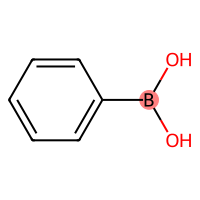
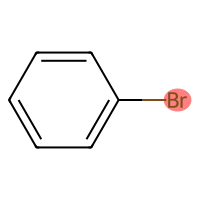
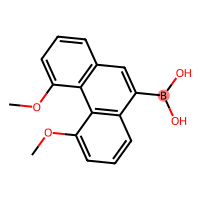
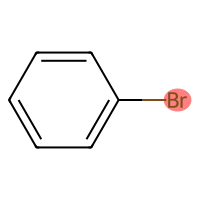
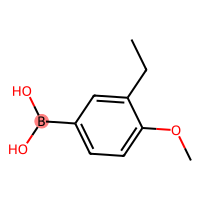
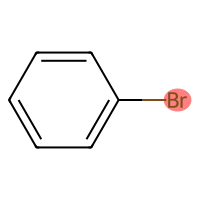
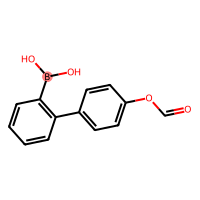
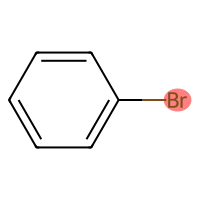
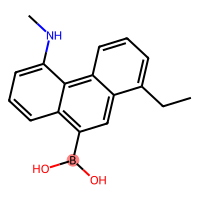
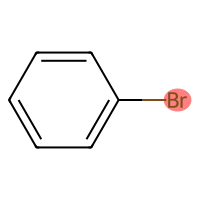
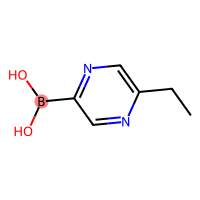
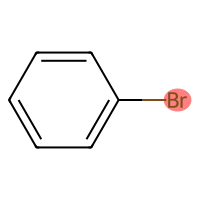
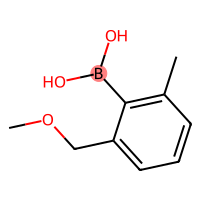
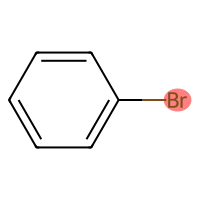
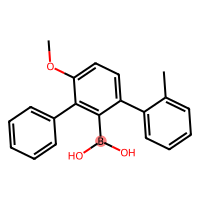
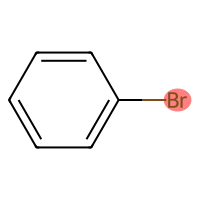
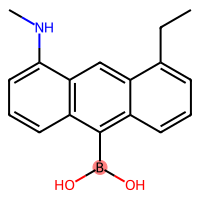
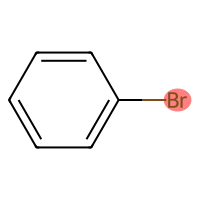
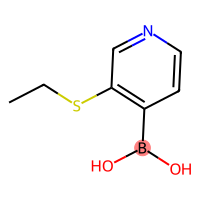
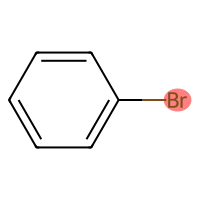
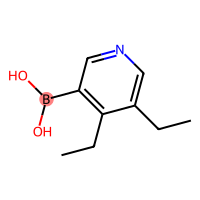
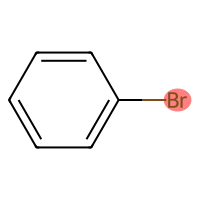
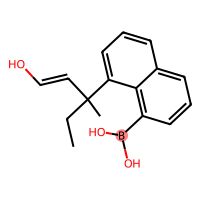
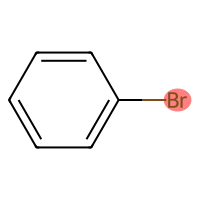
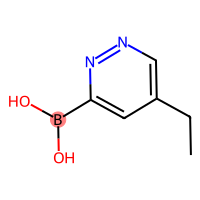
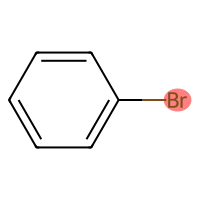
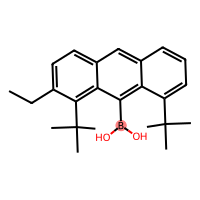
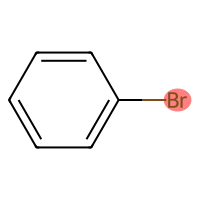
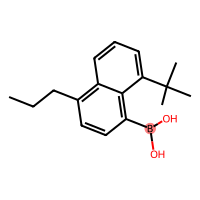
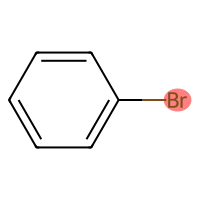
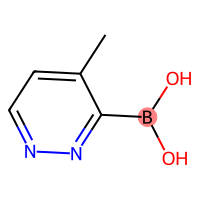
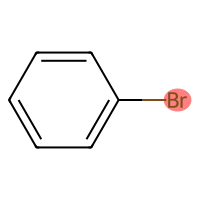
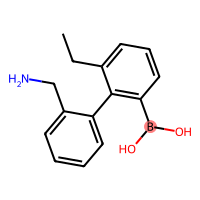
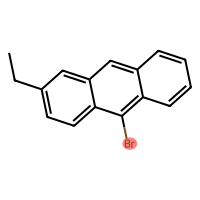
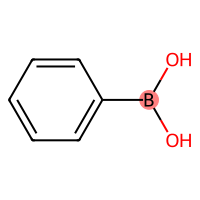
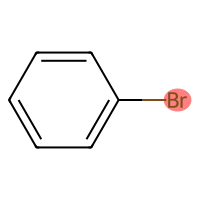
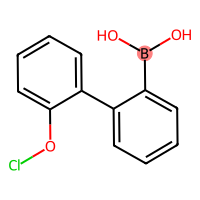
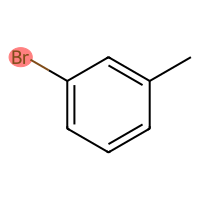
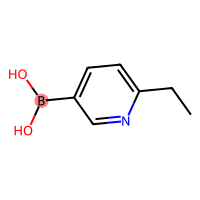
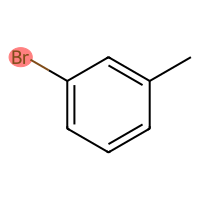
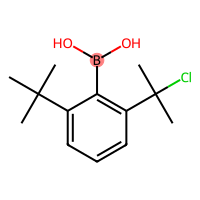
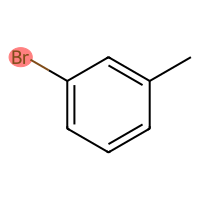
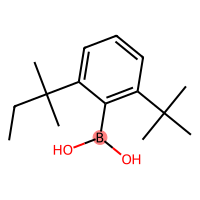
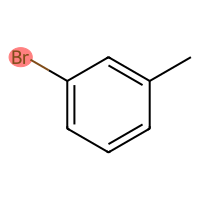
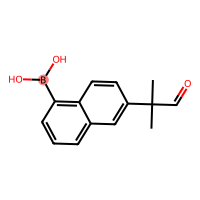
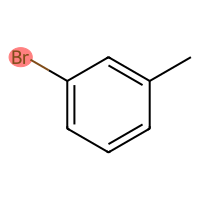
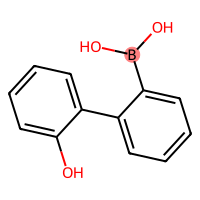
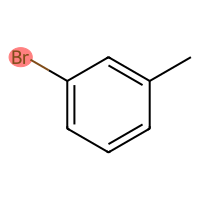
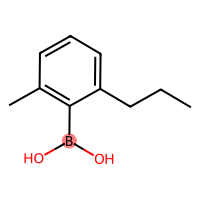
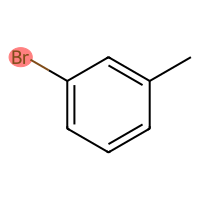
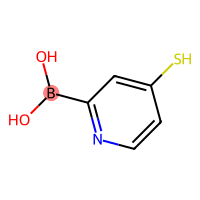
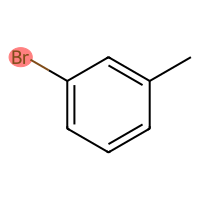
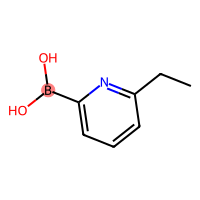
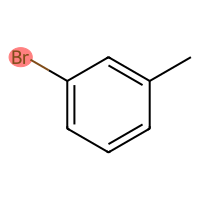
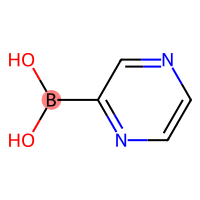
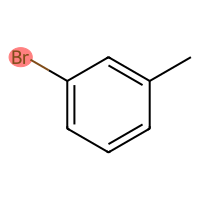
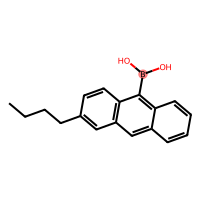
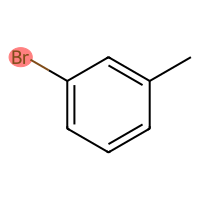
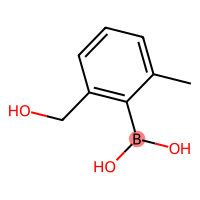
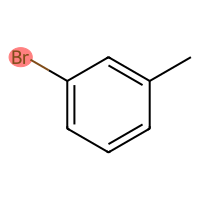
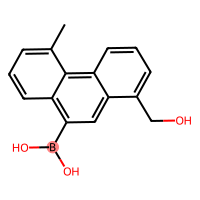
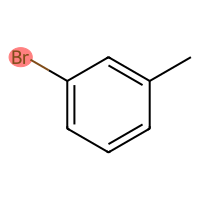
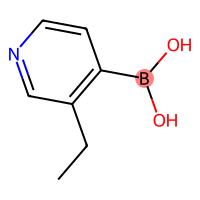
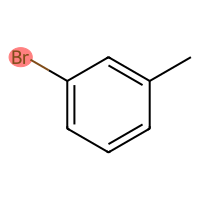
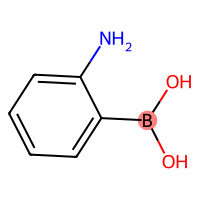
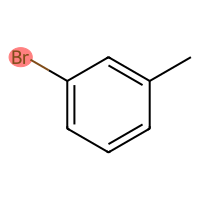
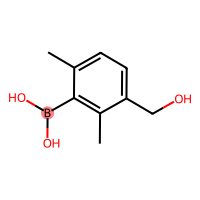
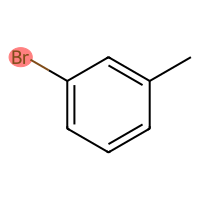
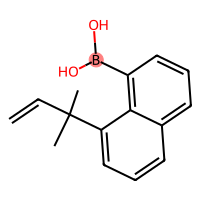
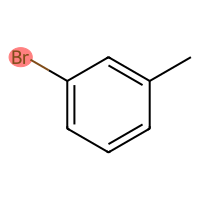
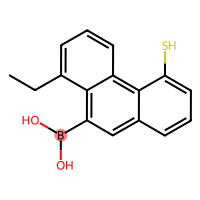
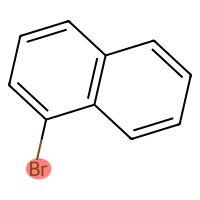
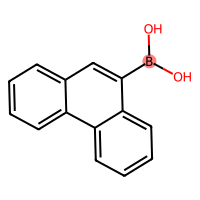
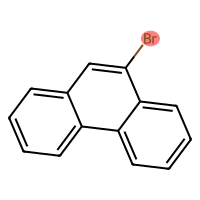
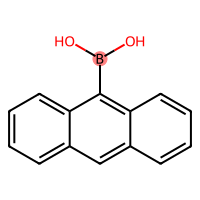
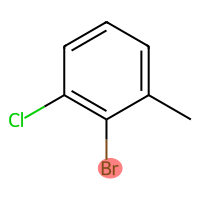
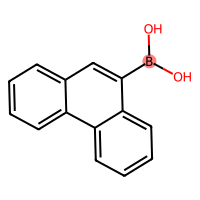
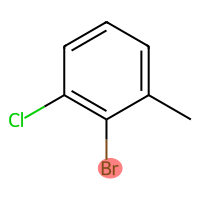
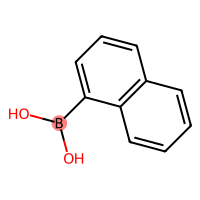
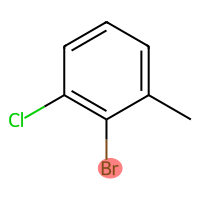
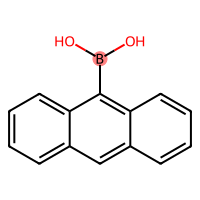
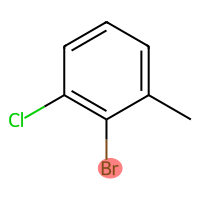
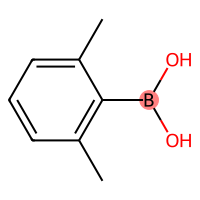

In [39]:
results[300:400]

In [25]:
# dfA = pd.DataFrame({'A': ['A1', 'A2', 'A3'], 'smiles_A': ['smiles1', 'smiles2', 'smiles3']})
# dfB = pd.DataFrame({'B': ['B1', 'B2'], 'smiles_B': ['smiles4', 'smiles5']})

In [26]:

# merged_results = pd.merge(dfA.assign(key=0), dfB.assign(key=0), on='key').drop('key', axis=1)

# #merged_results = merged_results.rename(columns={'A': 'col1', 'B': 'col2'})

# merged_results